# **Predictive Analytics - Peramalan Penjualan Produk Ritel Menggunakan Dataset Superstore untuk Mendukung Pengambilan Keputusan Strategis**

## **Deskripsi Proyek**

Dataset Sales Forecasting oleh Rohit Sahoo di Kaggle adalah kumpulan data yang dirancang untuk membantu dalam membangun model prediksi penjualan berdasarkan data historis. Dataset ini sering digunakan dalam proyek analisis data ritel dan peramalan penjualan yang dapat diakses melalui link berikut https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/data

## **Import Libraries**

In [1]:
!pip install kaggle catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

## **Data Understanding**

### **Load Data**

In [3]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rohitsahoo/sales-forecasting
!unzip sales-forecasting.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting
License(s): GPL-2.0
Archive:  sales-forecasting.zip
  inflating: train.csv               


In [4]:
superstore = pd.read_csv('train.csv')
superstore.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [5]:
superstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
superstore.duplicated().any()

np.False_

### **Cleaning Data**

In [7]:
superstore.dropna(axis=0, inplace=True)

In [8]:
superstore = superstore.drop(columns=['Row ID', 'Order ID', 'Customer ID', 'Product ID'])

In [9]:
superstore_raw = superstore.copy()

### **Exploratory Data Analysis (EDA)**

### Descriptive Statistics Overview

In [10]:
superstore.describe()

,Postal Code,Sales
count,9789.000000,9789.000000
mean,55273.322403,230.116193
std,32041.223413,625.302079
min,1040.000000,0.444000
25%,23223.000000,17.248000
50%,58103.000000,54.384000
75%,90008.000000,210.392000
max,99301.000000,22638.480000


Insight:
- Sales sangat bervariasi, dari sangat kecil (diskon kecil) sampai ribuan dolar.
- Distribusi Sales sangat tidak merata (skewed to the right), karena rata-rata jauh lebih besar dari median. Ini menunjukkan ada outlier atau transaksi sangat besar yang mempengaruhi statistik.
- Analisis lanjutan bisa mempertimbangkan transformasi log untuk stabilisasi data.

### Sales Distribution Overview

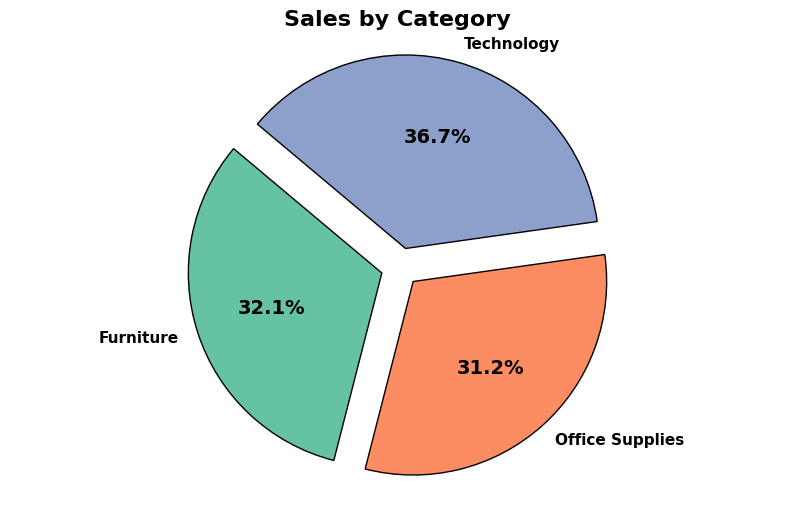

In [11]:
#Sales by category
sales_by_category = superstore.groupby('Category')['Sales'].sum().reset_index()
sns.set_theme(style="white", palette="muted")

fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette("Set2", len(sales_by_category))

explode = [0.1] * len(sales_by_category)

wedges, texts, autotexts = ax.pie(
    sales_by_category['Sales'],
    labels=sales_by_category['Category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 11, 'fontweight': 'bold', 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.0}
)

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.title('Sales by Category', fontsize=16, fontweight='bold', color='black')

plt.axis('equal')

plt.show()

Grafik pie ini menggambarkan distribusi penjualan berdasarkan kategori utama. Dari visualisasi terlihat bahwa kategori Technology memberikan kontribusi penjualan terbesar sebesar 36,7%, diikuti oleh Furniture dengan 32,1%, dan Office Supplies sebesar 31,2%. Perbedaan antar kategori tidak terlalu mencolok, namun tetap terlihat bahwa produk-produk teknologi memiliki peran dominan dalam total penjualan. Temuan ini menjadi indikasi awal bahwa kategori Technology memiliki potensi besar dan sebaiknya menjadi fokus dalam strategi penjualan ke depan.

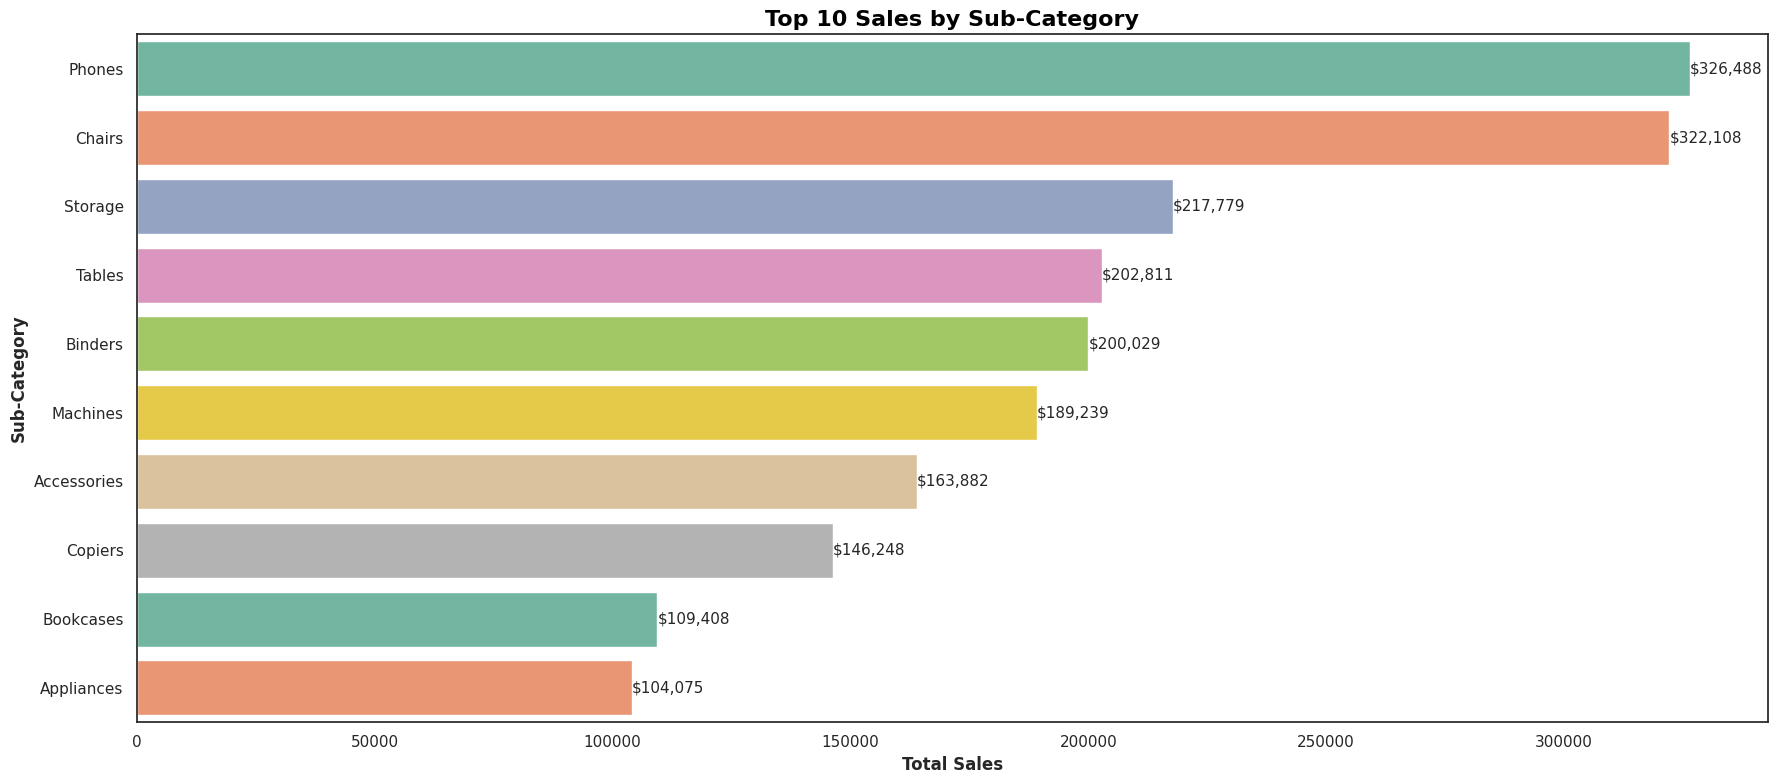

In [12]:
#Sales by sub category
sales_by_sub_category = superstore.groupby('Sub-Category')['Sales'].sum().reset_index()
sales_by_sub_category = sales_by_sub_category.sort_values(by='Sales', ascending=False).head(10)
sns.set_theme(style="white", palette="muted")

plt.figure(figsize=(18, 8))

colors = sns.color_palette("Set2", len(sales_by_sub_category))

sns.barplot(
    x='Sales',
    y='Sub-Category',
    data=sales_by_sub_category,
    palette=colors
)

plt.title('Top 10 Sales by Sub-Category', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Total Sales', fontsize=12, fontweight='bold')
plt.ylabel('Sub-Category', fontsize=12, fontweight='bold')

for index, value in enumerate(sales_by_sub_category['Sales']):
    plt.text(value + 10, index, f"${value:,.0f}", va='center', fontsize=11)

plt.tight_layout()
plt.show()

Grafik ini menampilkan sub-kategori dengan total penjualan tertinggi. Sub-kategori Phones mencatat penjualan sebesar USD 326.488, disusul oleh Chairs dengan USD 322.108. Sub-kategori lain seperti Storage, Tables, dan Binders mengikuti di posisi berikutnya. Mayoritas sub-kategori teratas berasal dari kategori Technology dan Furniture, yang konsisten dengan distribusi penjualan pada grafik pie sebelumnya.

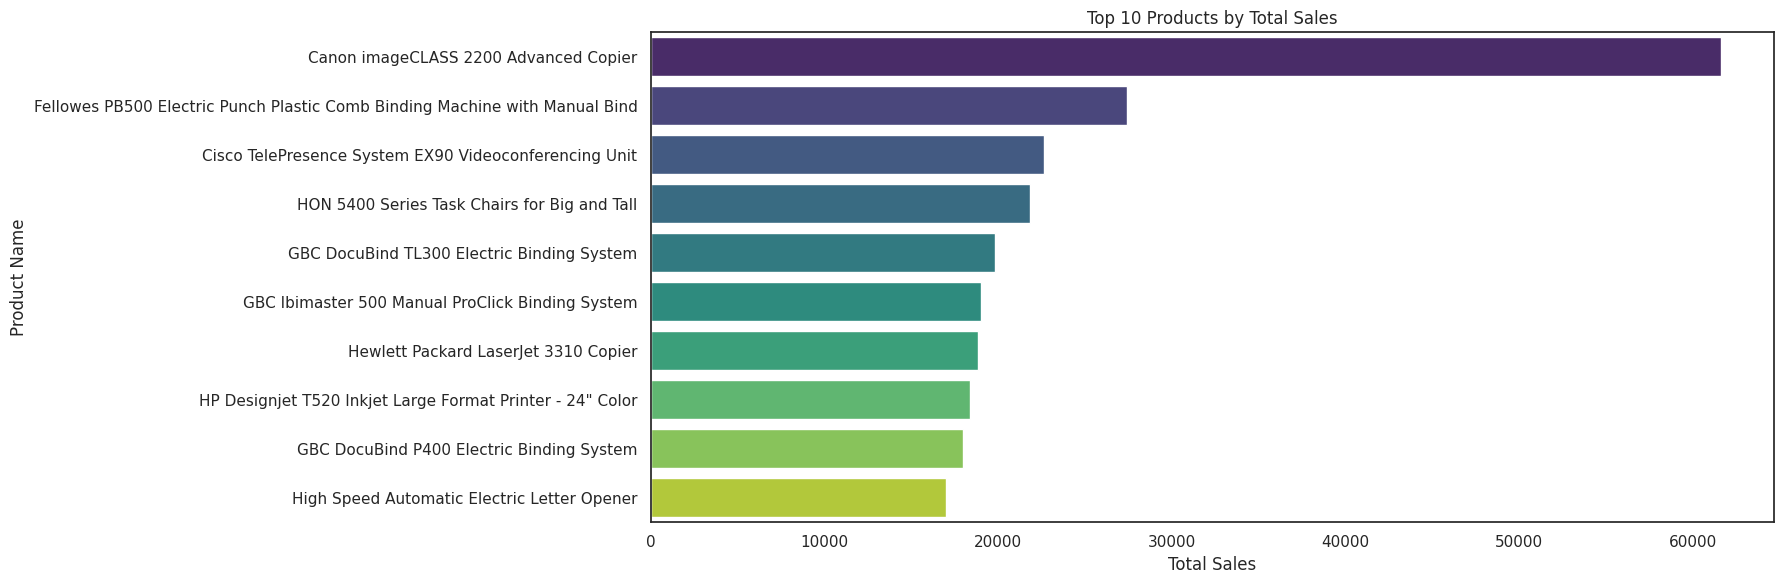

In [13]:
top_products = superstore.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(18,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

Grafik batang ini menampilkan sepuluh produk dengan total penjualan tertinggi secara individu. Produk dengan performa penjualan paling tinggi adalah Canon imageCLASS 2200 Advanced Copier, yang berhasil mencatatkan penjualan lebih dari 60.000 USD. Di bawahnya, terdapat sejumlah produk perkantoran lainnya seperti Binding Machines, Cisco Video System, dan HP Printers.

### Sales by Geography

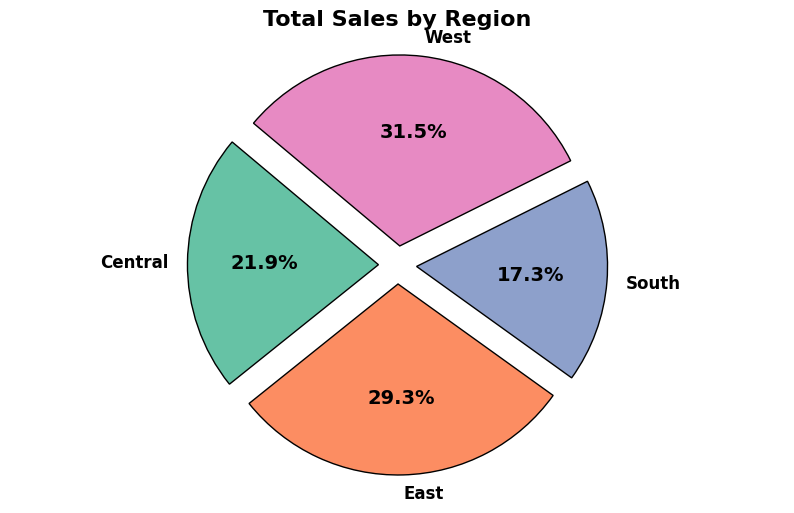

In [14]:
#Sales by region
sales_by_region = superstore.groupby('Region')['Sales'].sum().reset_index()
sns.set_theme(style="white", palette="muted")

fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette("Set2", len(sales_by_region))

explode = [0.1] * len(sales_by_region)

wedges, texts, autotexts = ax.pie(
    sales_by_region['Sales'],
    labels=sales_by_region['Region'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.0}
)

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.title('Total Sales by Region', fontsize=16, fontweight='bold', color='black')

plt.axis('equal')

plt.show()

Analisis geografis terhadap total penjualan mengungkap bahwa wilayah West menyumbang porsi penjualan terbesar secara regional, yaitu sebesar 31.5%, diikuti oleh East dengan 29.3%. Wilayah Central dan South tertinggal dengan masing-masing 21.9% dan 17.3%.

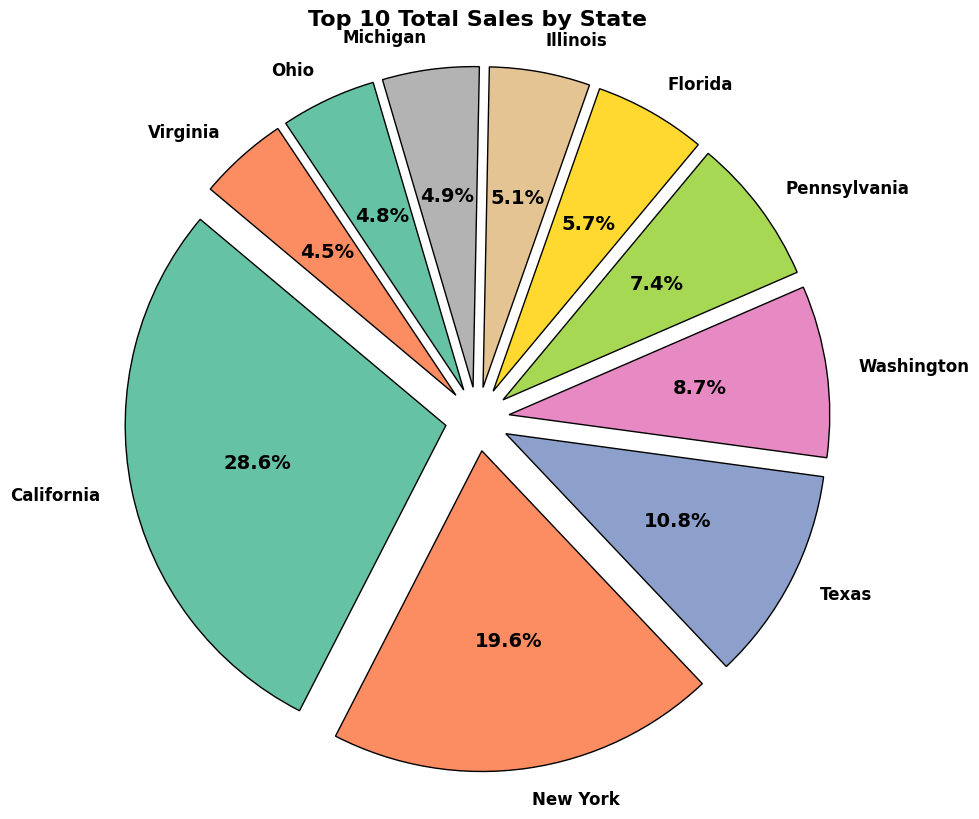

In [15]:
#Sales by state
sales_by_state = superstore.groupby('State')['Sales'].sum().reset_index()
sales_by_state = sales_by_state.sort_values(by='Sales', ascending=False).head(10)
sns.set_theme(style="white", palette="muted")

fig, ax = plt.subplots(figsize=(10, 10))

colors = sns.color_palette("Set2", len(sales_by_state))

explode = [0.1] * len(sales_by_state)

wedges, texts, autotexts = ax.pie(
    sales_by_state['Sales'],
    labels=sales_by_state['State'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.0}
)

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.title('Top 10 Total Sales by State', fontsize=16, fontweight='bold', color='black')

plt.axis('equal')

plt.show()

Jika dilihat lebih mendetail berdasarkan negara bagian, California mendominasi dengan kontribusi sebesar 28.6% dari total penjualan di antara 10 negara bagian teratas, disusul oleh New York (19.6%) dan Texas (10.8%).

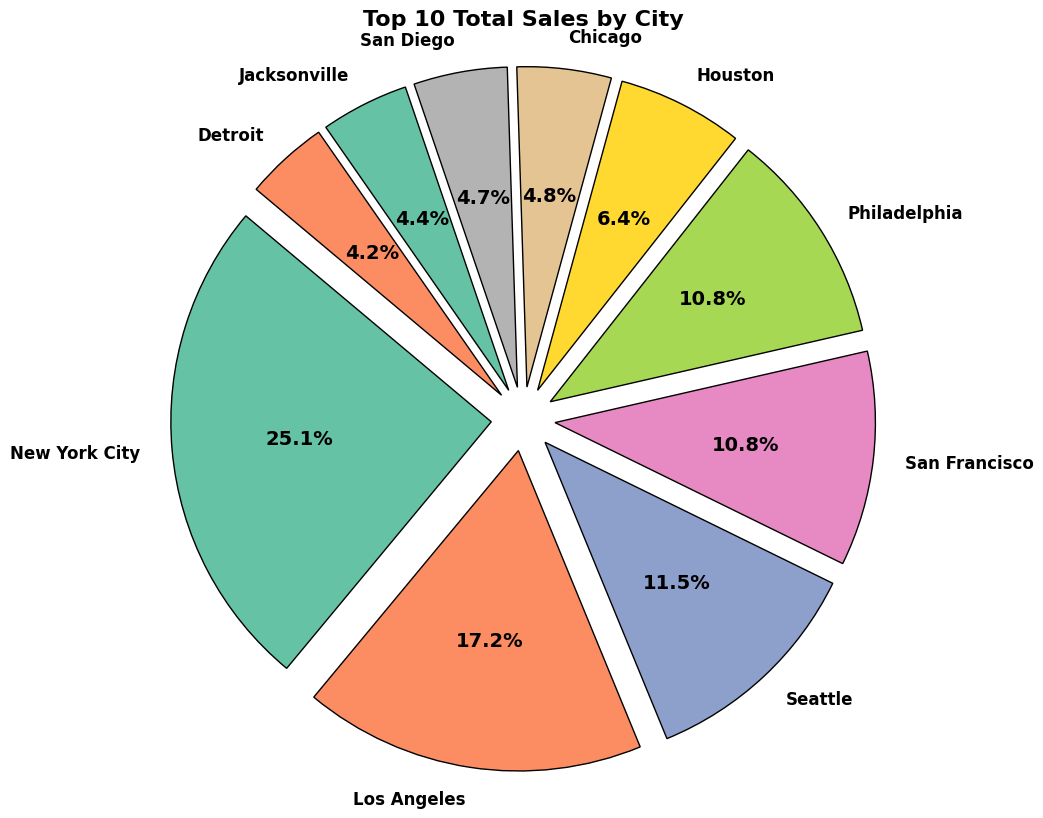

In [16]:
#Sales by city
sales_by_city = superstore.groupby('City')['Sales'].sum().reset_index()
sales_by_city = sales_by_city.sort_values(by='Sales', ascending=False).head(10)
sns.set_theme(style="white", palette="muted")

fig, ax = plt.subplots(figsize=(10, 10))

colors = sns.color_palette("Set2", len(sales_by_city))

explode = [0.1] * len(sales_by_city)

wedges, texts, autotexts = ax.pie(
    sales_by_city['Sales'],
    labels=sales_by_city['City'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.0}
)

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.title('Top 10 Total Sales by City', fontsize=16, fontweight='bold', color='black')

plt.axis('equal')

plt.show()

Sementara itu, pada tingkat kota, New York City memimpin dengan pangsa penjualan sebesar 25.1%, diikuti oleh Los Angeles (17.2%) dan Seattle (11.5%). Secara keseluruhan, pola ini menunjukkan bahwa penjualan paling kuat terkonsentrasi di wilayah pesisir seperti California dan New York, yang juga merupakan pusat ekonomi besar di Amerika Serikat.

### Sales by Customer Segment

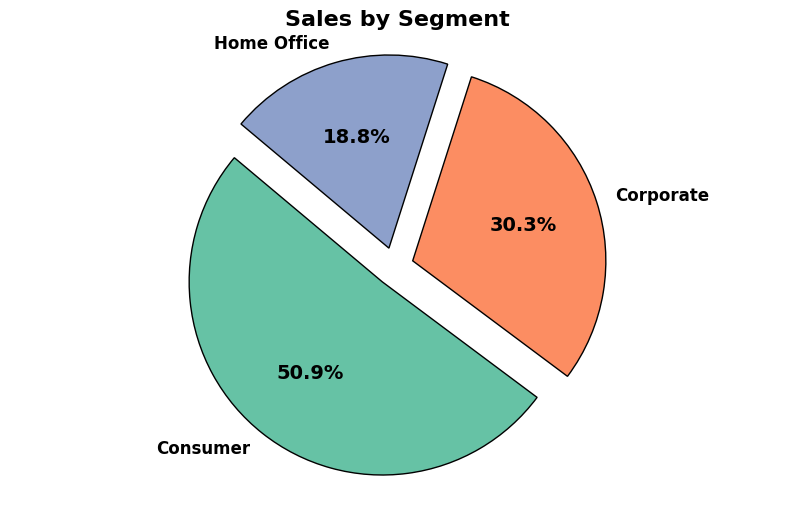

In [17]:
sales_by_segment = superstore.groupby('Segment')['Sales'].sum().reset_index()
sns.set_theme(style="white", palette="muted")

fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette("Set2", len(sales_by_segment))

explode = [0.1] * len(sales_by_segment)

wedges, texts, autotexts = ax.pie(
    sales_by_segment['Sales'],
    labels=sales_by_segment['Segment'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.0},
)

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax.set_title('Sales by Segment', fontsize=16, fontweight='bold', color='black')
ax.axis('equal')

plt.show()

Distribusi penjualan berdasarkan segmen pelanggan menunjukkan bahwa segmen Consumer merupakan penyumbang terbesar dengan 50.9% dari total penjualan. Segmen Corporate berada di posisi kedua dengan kontribusi sebesar 30.3%, sementara Home Office menyumbang 18.8%. Temuan ini mengindikasikan bahwa pelanggan individu atau konsumen umum menjadi pasar utama dalam penjualan produk, diikuti oleh segmen bisnis besar dan kantor rumahan.

### Top 10 Customers by Sales

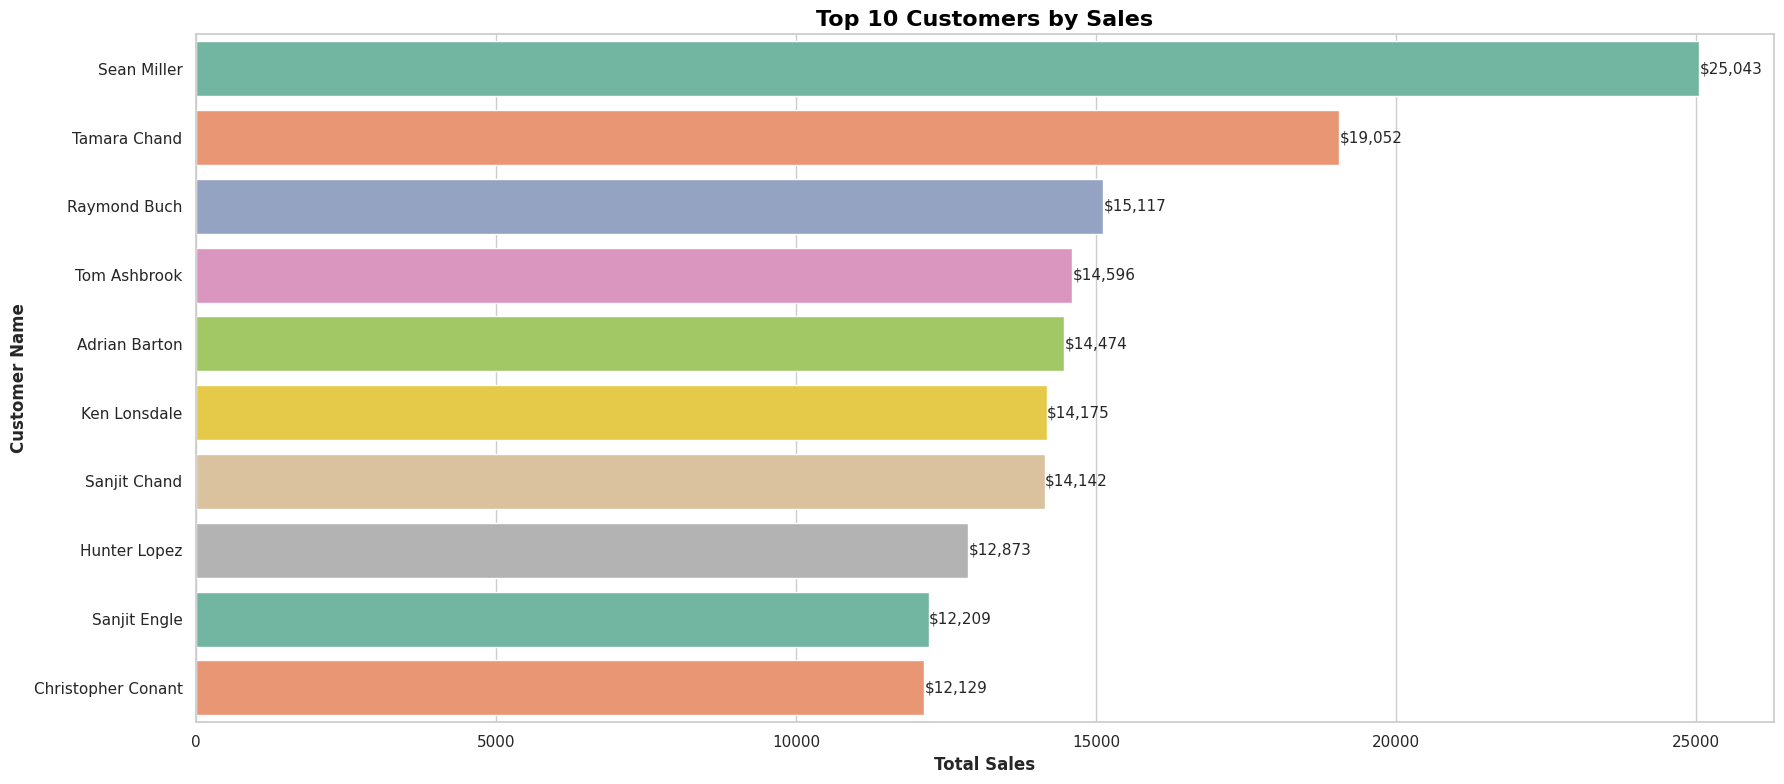

In [18]:
top_customers = superstore.groupby('Customer Name')['Sales'].sum().reset_index()

top_customers = top_customers.sort_values(by='Sales', ascending=False).head(10)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(18, 8))

colors = sns.color_palette("Set2", len(top_customers))

sns.barplot(
    x='Sales',
    y='Customer Name',
    data=top_customers,
    palette=colors
)

plt.title('Top 10 Customers by Sales', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Total Sales', fontsize=12, fontweight='bold')
plt.ylabel('Customer Name', fontsize=12, fontweight='bold')

for index, value in enumerate(top_customers['Sales']):
    plt.text(value + 10, index, f"${value:,.0f}", va='center', fontsize=11)

plt.tight_layout()
plt.show()

Daftar pelanggan dengan kontribusi penjualan tertinggi menunjukkan bahwa Sean Miller merupakan pelanggan paling bernilai, dengan total pembelian mencapai lebih dari USD 25.000. Diikuti oleh Tamara Chand dengan hampir USD 19.000 penjualan, serta beberapa nama lain seperti Raymond Buch, Tom Ashbrook, dan Adrian Barton, yang masing-masing menyumbang lebih dari USD 14.000. Pola ini menunjukkan bahwa terdapat kelompok pelanggan kunci dengan kontribusi besar terhadap pendapatan. Pelanggan-pelanggan ini bisa menjadi fokus program loyalitas, penawaran eksklusif, atau pendekatan penjualan yang lebih personal untuk mempertahankan dan meningkatkan nilai mereka ke depannya.

### Shipping Analysis

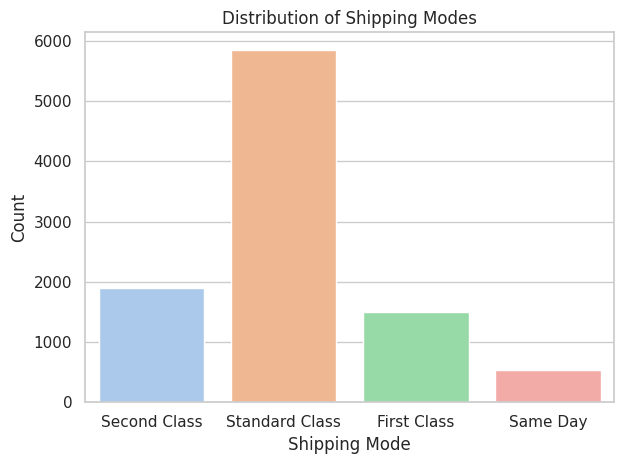

In [19]:
sns.countplot(data=superstore, x='Ship Mode', palette='pastel')
plt.title('Distribution of Shipping Modes')
plt.xlabel('Shipping Mode')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Grafik ini menunjukkan distribusi mode pengiriman yang digunakan pelanggan. Dari grafik tersebut, terlihat bahwa Standard Class merupakan metode pengiriman yang paling sering dipilih, dengan jumlah pengiriman mendekati 6.000 kali. Hal ini menunjukkan bahwa pelanggan cenderung memilih opsi pengiriman yang lebih ekonomis dan cukup andal. Second Class berada di urutan kedua, diikuti oleh First Class, sedangkan Same Day merupakan metode pengiriman yang paling jarang digunakan, kemungkinan karena biaya yang lebih tinggi atau keterbatasan layanan.

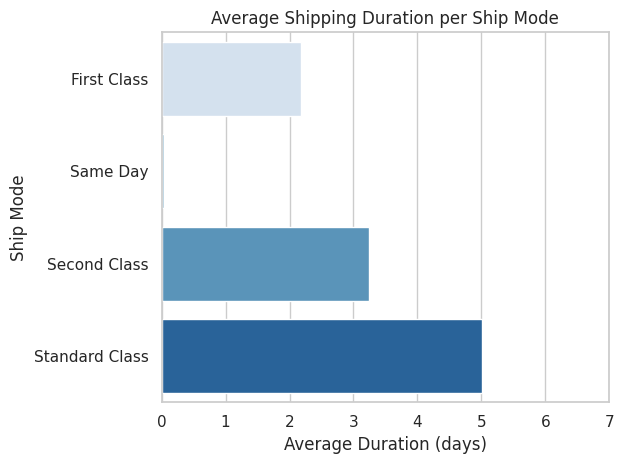

In [20]:
# Konversi tanggal dan hitung durasi
superstore['Order Date'] = pd.to_datetime(superstore['Order Date'], format='%d/%m/%Y')
superstore['Ship Date'] = pd.to_datetime(superstore['Ship Date'], format='%d/%m/%Y')
superstore['Shipping Duration'] = (superstore['Ship Date'] - superstore['Order Date']).dt.days

# Filter hanya yang Shipping Duration <= 7 hari
filtered_data = superstore[superstore['Shipping Duration'] <= 7]
avg_ship_duration = filtered_data.groupby('Ship Mode')['Shipping Duration'].mean().reset_index()

sns.barplot(data=avg_ship_duration, x='Shipping Duration', y='Ship Mode', palette='Blues')
plt.title('Average Shipping Duration per Ship Mode')
plt.xlabel('Average Duration (days)')
plt.ylabel('Ship Mode')
plt.xlim(0, 7)
plt.tight_layout()
plt.show()


Sementara itu, grafik kedua menunjukkan rata-rata durasi pengiriman untuk setiap mode. Standard Class memiliki rata-rata waktu pengiriman terlama, yaitu sekitar 5 hari. Di sisi lain, Same Day konsisten dengan namanya, memberikan pengiriman dalam waktu kurang dari satu hari. First Class memiliki durasi rata-rata sekitar 2 hari, dan Second Class memerlukan waktu sekitar 3 hari. Pola ini menunjukkan trade-off yang jelas antara kecepatan dan popularitas: meskipun Standard Class memerlukan waktu lebih lama, ia tetap menjadi pilihan utama pelanggan, kemungkinan karena efisiensi biaya.

### Sales Trend Over Time

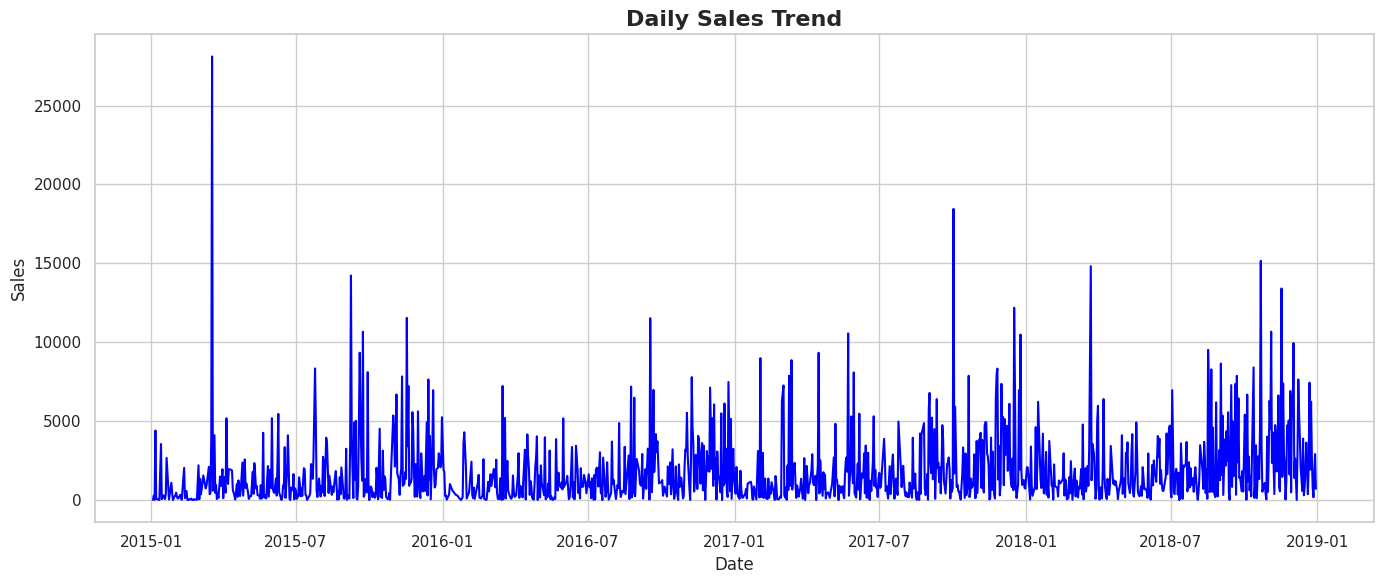

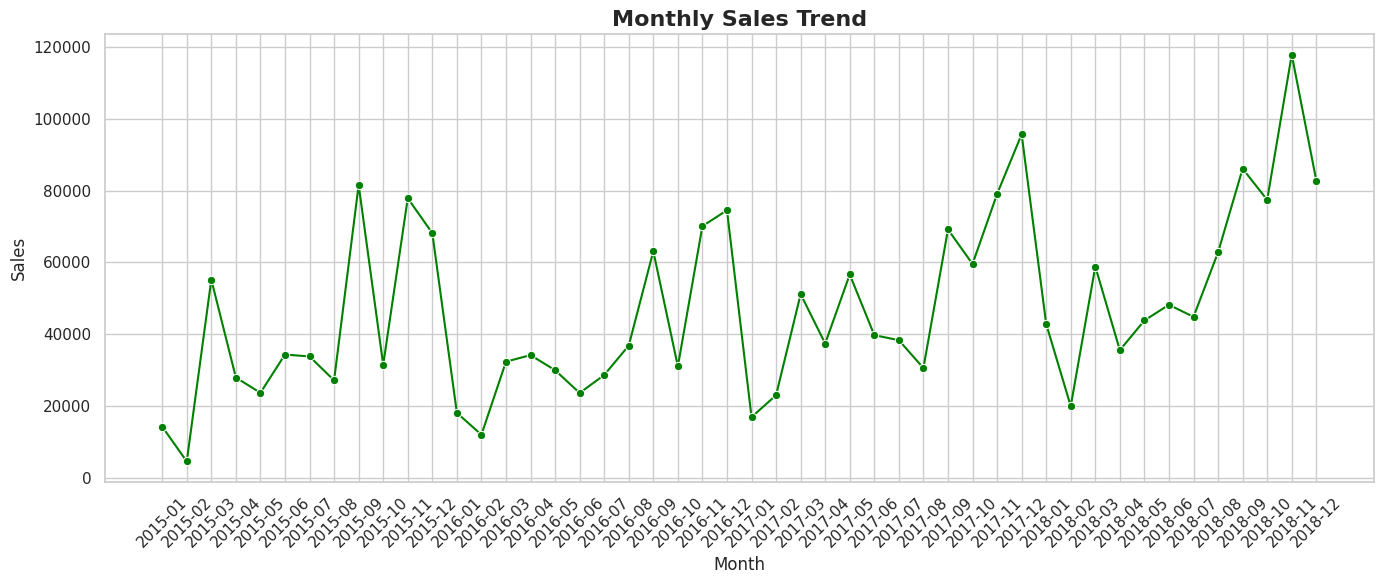

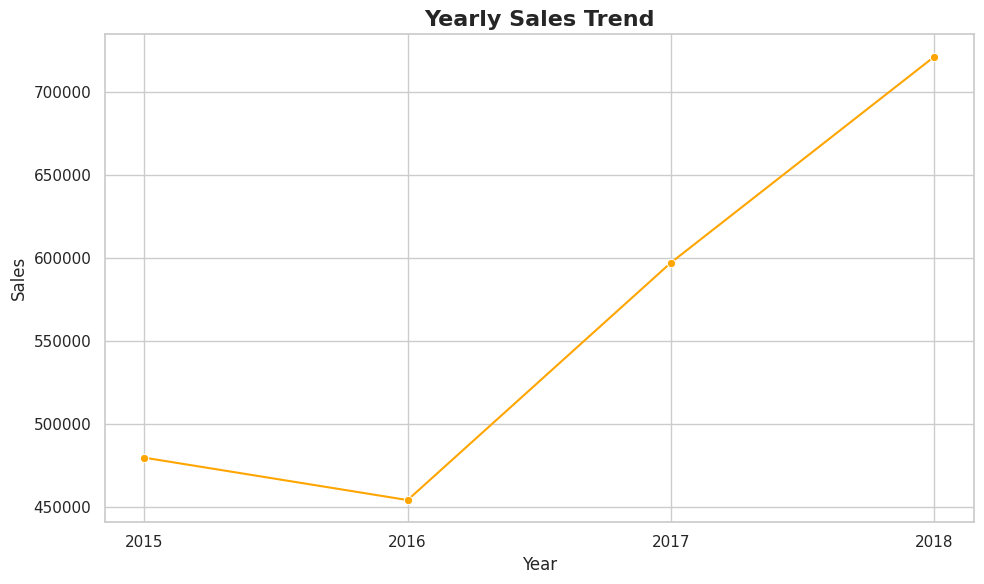

In [21]:
daily_sales = superstore.groupby('Order Date')['Sales'].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='Order Date', y='Sales', color='blue')
plt.title('Daily Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

superstore['Month'] = superstore['Order Date'].dt.to_period('M').astype(str)
monthly_sales = superstore.groupby('Month')['Sales'].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', marker='o', color='green')
plt.xticks(rotation=45)
plt.title('Monthly Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

superstore['Year'] = superstore['Order Date'].dt.year
yearly_sales = superstore.groupby('Year')['Sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_sales, x='Year', y='Sales', marker='o', color='orange')
plt.title('Yearly Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.xticks(yearly_sales['Year'])
plt.tight_layout()
plt.show()

- Daily Sales Trend

Penjualan harian dari 2015 hingga 2018 menunjukkan fluktuasi tinggi dengan lonjakan tajam di beberapa titik, seperti awal 2015. Meski data cukup “berisik”, tren keseluruhan cenderung naik, menandakan pertumbuhan aktivitas harian yang dinamis, kemungkinan karena pengaruh musiman dan promo.

- Monthly Sales Trend

Penjualan bulanan tampak naik turun, tapi secara umum meningkat. Lonjakan sering terjadi di akhir tahun, terutama Desember 2018 yang hampir mencapai 120.000. Ini menunjukkan adanya pola musiman, seperti peningkatan belanja saat liburan atau promo akhir tahun.

- Yearly Sales Trend

Total penjualan tahunan sempat turun dari 2015 ke 2016, lalu naik signifikan di 2017 dan 2018. Tahun 2018 mencatat penjualan tertinggi sekitar 720.000, mencerminkan pertumbuhan bisnis yang kuat dalam tiga tahun terakhir.

### Monthly Sales Pattern Year-to-Year

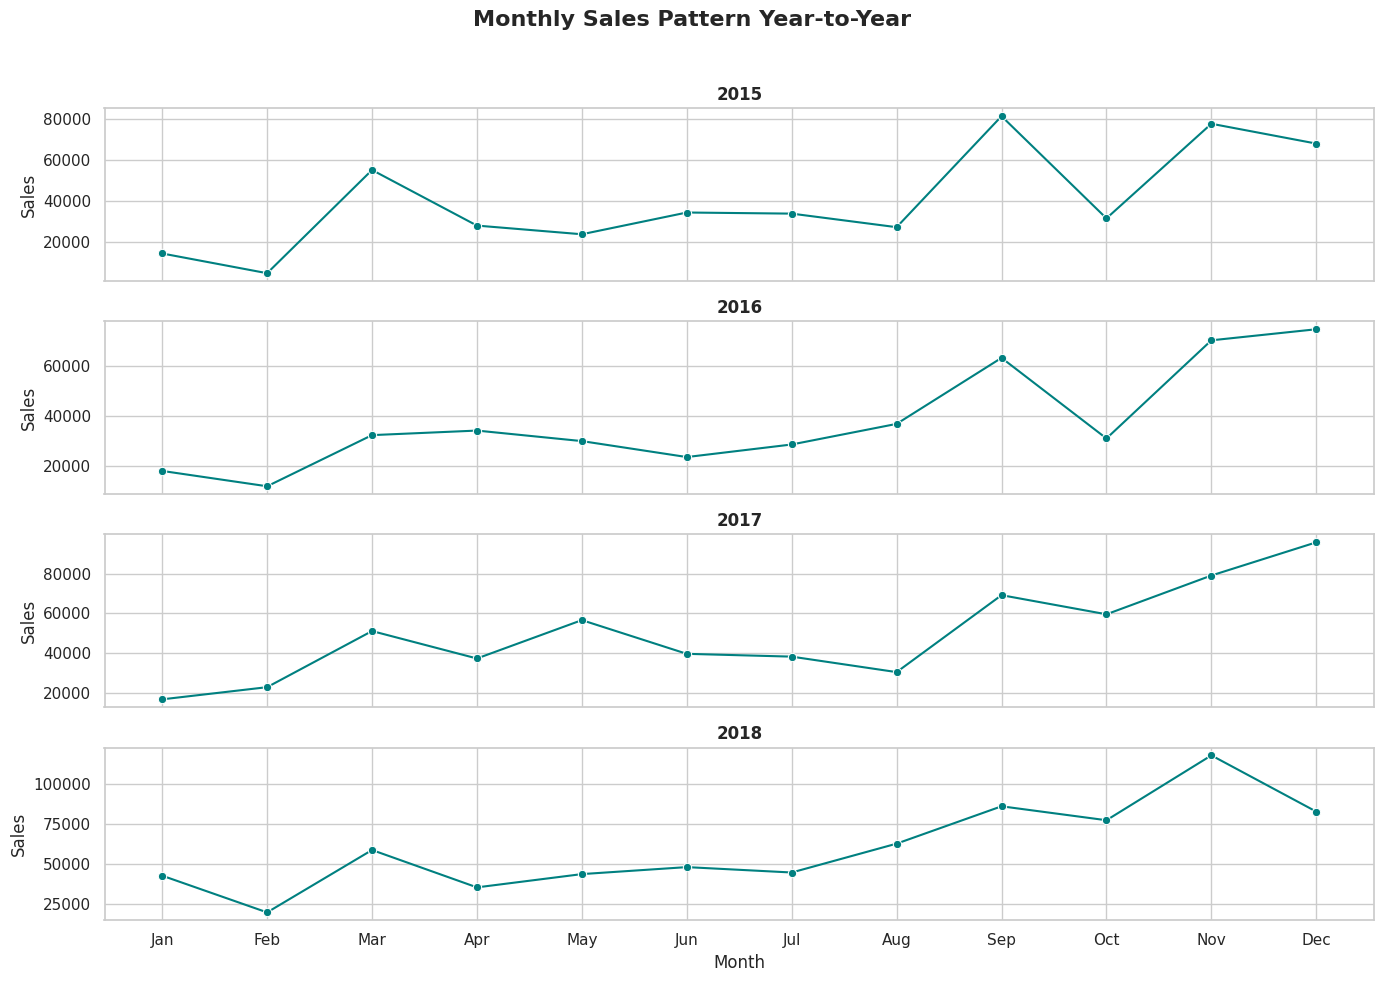

In [22]:
# Tambah kolom tahun dan bulan
superstore['Year'] = superstore['Order Date'].dt.year
superstore['Month'] = superstore['Order Date'].dt.strftime('%b')
superstore['Month_Num'] = superstore['Order Date'].dt.month

monthly_sales = superstore.groupby(['Year', 'Month', 'Month_Num'])['Sales'].sum().reset_index()
monthly_sales = monthly_sales.sort_values(by=['Year', 'Month_Num'])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)
years = sorted(monthly_sales['Year'].unique())

for i, year in enumerate(years):
    data = monthly_sales[monthly_sales['Year'] == year]
    sns.lineplot(data=data, x='Month', y='Sales', marker='o', ax=axes[i], color='teal')
    axes[i].set_title(f'{year}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Sales')

plt.xlabel('Month')
plt.suptitle('Monthly Sales Pattern Year-to-Year', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Grafik tersebut menunjukkan tren penjualan bulanan dari 2015 hingga 2018. Terlihat pola musiman yang konsisten, di mana penjualan cenderung rendah di awal tahun (Januari–Februari) dan meningkat tajam menjelang akhir tahun, khususnya di bulan November dan Desember. Lonjakan paling signifikan terjadi di November 2018, dengan penjualan mendekati 110.000. Dari tahun ke tahun, tren pertumbuhan penjualan terlihat jelas, terutama pada bulan-bulan puncak.

### Monthly Observation

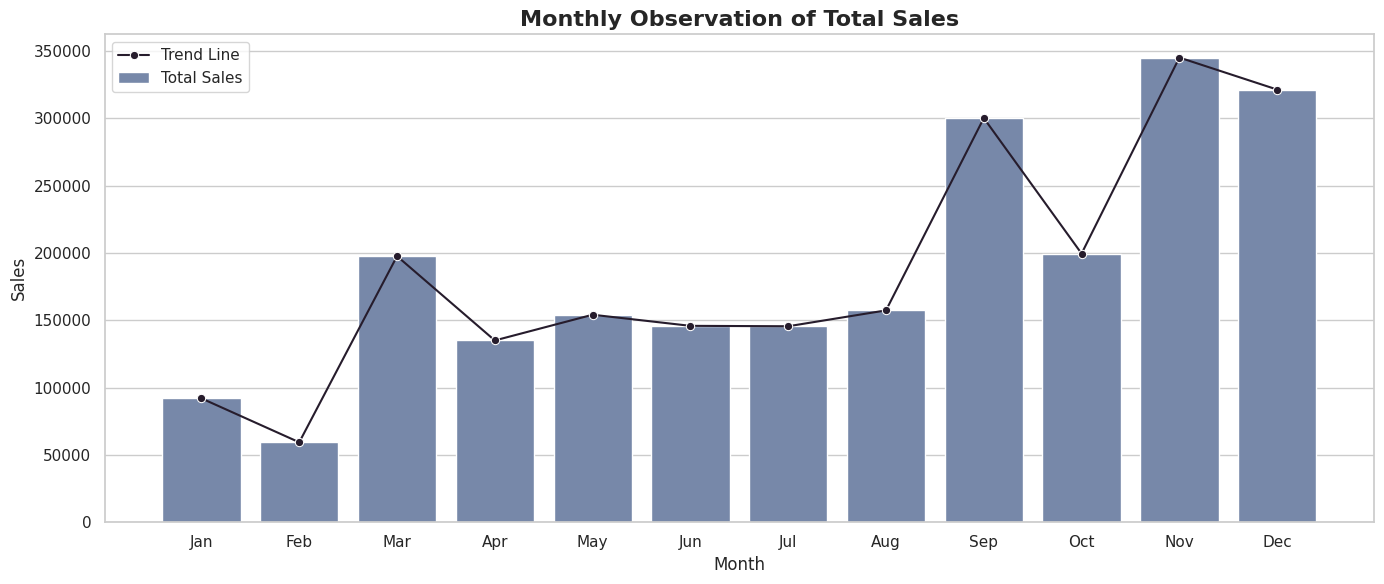

In [23]:
superstore['Month'] = superstore['Order Date'].dt.strftime('%b')
superstore['Month_Num'] = superstore['Order Date'].dt.month

monthly_sales = superstore.groupby(['Month', 'Month_Num'])['Sales'].sum().reset_index()
monthly_sales = monthly_sales.sort_values(by='Month_Num')

fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(data=monthly_sales, x='Month', y='Sales', color="#6E85B2", ax=ax, label='Total Sales')
sns.lineplot(data=monthly_sales, x='Month', y='Sales', marker='o', color="#261C2C", ax=ax, label='Trend Line')

plt.title('Monthly Observation of Total Sales', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

Grafik tersebut menunjukkan total penjualan per bulan secara agregat. Terlihat bahwa penjualan mengalami peningkatan signifikan di bulan-bulan tertentu, terutama Maret, September, November, dan Desember. November menjadi bulan dengan penjualan tertinggi, mencapai hampir 350.000, disusul oleh Desember. Sebaliknya, bulan Februari mencatatkan penjualan terendah. Selain itu, garis tren menunjukkan fluktuasi yang cukup tajam antar bulan, mencerminkan dinamika permintaan konsumen yang kuat sepanjang tahun.

### Numerical Feature Correlation

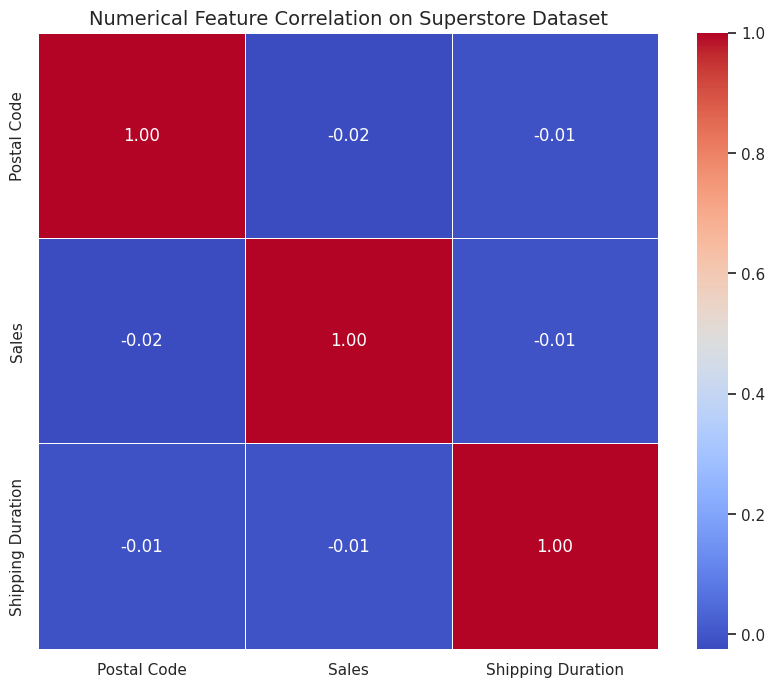

In [24]:
numeric_df = superstore.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Numerical Feature Correlation on Superstore Dataset', fontsize=14)
plt.show()

Hasil dari grafik heatmap menunjukkan tidak ada korelasi signifikan antar ketiganya, dengan nilai korelasi sangat rendah (dekat 0). Artinya, fitur-fitur ini cenderung independen satu sama lain dan tidak saling memengaruhi secara linier.

### Sales Distribution & Outlier detection

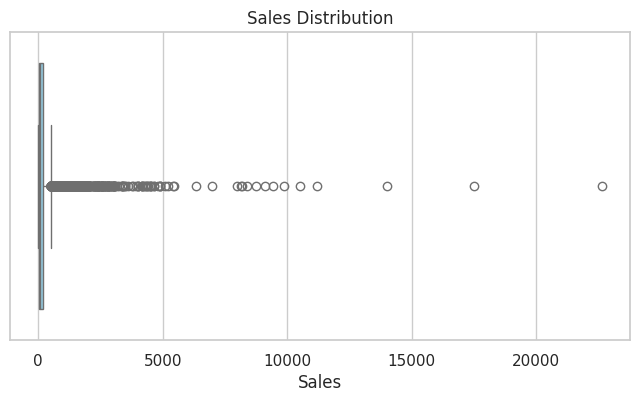

In [25]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=superstore['Sales'], color='skyblue')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.show()

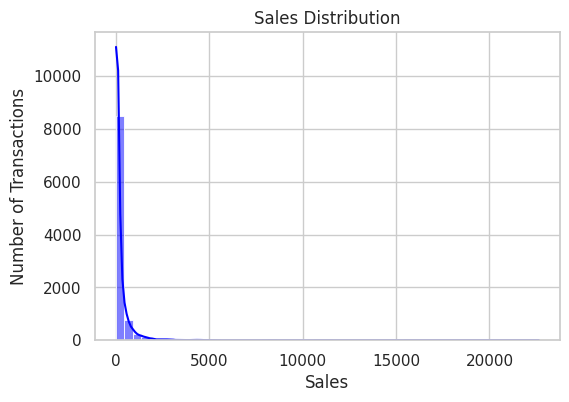

In [26]:
plt.figure(figsize=(6, 4))
sns.histplot(superstore['Sales'], kde=True, bins=50, color='blue')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Number of Transactions')
plt.show()


Distribusi penjualan menunjukkan data yang skew ke kanan, di mana sebagian besar transaksi berada di kisaran rendah (sekitar 0–500), sementara hanya sedikit transaksi dengan nilai sangat tinggi yang menjadi outlier. Hal ini mengindikasikan ketidakseimbangan pada data penjualan.

## **Data Preparation**

In [27]:
superstore_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9789 entries, 0 to 9799
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order Date     9789 non-null   object 
 1   Ship Date      9789 non-null   object 
 2   Ship Mode      9789 non-null   object 
 3   Customer Name  9789 non-null   object 
 4   Segment        9789 non-null   object 
 5   Country        9789 non-null   object 
 6   City           9789 non-null   object 
 7   State          9789 non-null   object 
 8   Postal Code    9789 non-null   float64
 9   Region         9789 non-null   object 
 10  Category       9789 non-null   object 
 11  Sub-Category   9789 non-null   object 
 12  Product Name   9789 non-null   object 
 13  Sales          9789 non-null   float64
dtypes: float64(2), object(12)
memory usage: 1.1+ MB


In [28]:
# Log transformation
superstore_raw['log_sales'] = np.log1p(superstore_raw['Sales'])  # log(1 + x)

In [29]:
# Outlier Detection and Removal (IQR)
Q1 = superstore_raw['Sales'].quantile(0.25)
Q3 = superstore_raw['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
superstore_raw_clean = superstore_raw[(superstore_raw['Sales'] >= lower_bound) & (superstore_raw['Sales'] <= upper_bound)]

In [30]:
# Feature Engineering
df = superstore_raw_clean.copy()
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')
df['Shipping Duration'] = (df['Ship Date'] - df['Order Date']).dt.days
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Weekday'] = df['Order Date'].dt.dayofweek
df['Quarter'] = df['Order Date'].dt.quarter  # Additional feature
df['Is_Holiday'] = df['Order Date'].dt.month.isin([12, 1])  # Example of holiday season

# Encode categorical variables for tabular models
rf_data = df.copy()
le = LabelEncoder()
for col in ['Category', 'Sub-Category', 'Region', 'Segment', 'Ship Mode', 'Country', 'City', 'State']:
    rf_data[col] = le.fit_transform(rf_data[col])

# Prepare LSTM Data
features = ['Sales', 'Shipping Duration', 'Year', 'Month', 'Day']
lstm_data = df[features + ['Order Date']].sort_values('Order Date').reset_index(drop=True)
scaler = MinMaxScaler()
lstm_scaled = pd.DataFrame(scaler.fit_transform(lstm_data[features]), columns=features)

# Create LSTM sequences
def create_lstm_sequences(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size]['Sales'])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_lstm_sequences(lstm_scaled, window_size=3)

train_size = int(len(X_lstm) * 0.7)
val_size = int(len(X_lstm) * 0.15)

X_train_lstm = X_lstm[:train_size]
y_train_lstm = y_lstm[:train_size]
X_val_lstm = X_lstm[train_size:train_size+val_size]
y_val_lstm = y_lstm[train_size:train_size+val_size]
X_test_lstm = X_lstm[train_size+val_size:]
y_test_lstm = y_lstm[train_size+val_size:]

In [31]:
# Prepare training data for tabular models
X_rf = rf_data.drop(columns=['Sales', 'Order Date', 'Ship Date', 'Customer Name', 'Product Name'])
y_rf = rf_data['Sales']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_test_rf, y_test_rf, test_size=0.5, random_state=42)

## **Modeling**

In [32]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    return (
        mean_absolute_error(y_test, pred),
        mean_squared_error(y_test, pred),
        np.sqrt(mean_squared_error(y_test, pred)),
        r2_score(y_test, pred),
        pred
    )

### **Random Forest**

In [33]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
rf_mae, rf_mse, rf_rmse, rf_r2, rf_pred = evaluate_model(rf_model, X_test_rf, y_test_rf)

## **XGBoost**

In [34]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_rf, y_train_rf)
xgb_mae, xgb_mse, xgb_rmse, xgb_r2, xgb_pred = evaluate_model(xgb_model, X_test_rf, y_test_rf)

## **Catboost**

In [35]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train_rf, y_train_rf)
cat_mae, cat_mse, cat_rmse, cat_r2, cat_pred = evaluate_model(cat_model, X_test_rf, y_test_rf)

## **LSTM**

In [36]:
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32,
               validation_data=(X_val_lstm, y_val_lstm), verbose=1)

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0575 - val_loss: 0.0530
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0543 - val_loss: 0.0539
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0573 - val_loss: 0.0530
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0550 - val_loss: 0.0529
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0546 - val_loss: 0.0533
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0531 - val_loss: 0.0529
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0581 - val_loss: 0.0538
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0528 - val_loss: 0.0532
Epoch 9/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0519 - val_loss: 0.0529
Epoch 10/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0538 - val_loss: 0.0532
Epoch 11/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0541 - val_loss: 0.0529
Epoch 12/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [37]:
lstm_pred_scaled = lstm_model.predict(X_test_lstm)

dummy = np.zeros((len(lstm_pred_scaled), len(features)))
dummy[:, features.index('Sales')] = lstm_pred_scaled.flatten()
lstm_pred_original = scaler.inverse_transform(dummy)[:, features.index('Sales')]

dummy[:, features.index('Sales')] = y_test_lstm.flatten()
y_test_lstm_original = scaler.inverse_transform(dummy)[:, features.index('Sales')]

mae_lstm = mean_absolute_error(y_test_lstm_original, lstm_pred_original)
mse_lstm = mean_squared_error(y_test_lstm_original, lstm_pred_original)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_lstm_original, lstm_pred_original)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## **Model Evaluation**

In [38]:
results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CatBoost", "LSTM"],
    "MAE": [rf_mae, xgb_mae, cat_mae, mae_lstm],
    "MSE": [rf_mse, xgb_mse, cat_mse, mse_lstm],
    "RMSE": [rf_rmse, xgb_rmse, cat_rmse, rmse_lstm],
    "R2": [rf_r2, xgb_r2, cat_r2, r2_lstm]
})
print(results)

           Model        MAE           MSE        RMSE        R2
0  Random Forest   0.061773      0.021770    0.147546  0.999998
1        XGBoost   0.609670      1.642140    1.281460  0.999886
2       CatBoost   0.763892      2.636579    1.623755  0.999817
3           LSTM  85.582162  11976.668554  109.437967 -0.011307


Tabel evaluasi menunjukkan bahwa model Random Forest memberikan performa terbaik dengan nilai MAE, MSE, dan RMSE yang paling rendah, serta skor R² hampir sempurna (0.999998), menandakan prediksi sangat akurat dan hampir identik dengan data aktual.

Model XGBoost dan CatBoost juga menunjukkan performa yang sangat baik dengan skor R² > 0.999, meskipun sedikit di bawah Random Forest.
Sebaliknya, model LSTM memiliki performa yang sangat buruk dibandingkan model lainnya, dengan nilai error yang sangat tinggi dan skor R² negatif (-0.006), menandakan model gagal menangkap pola pada data.

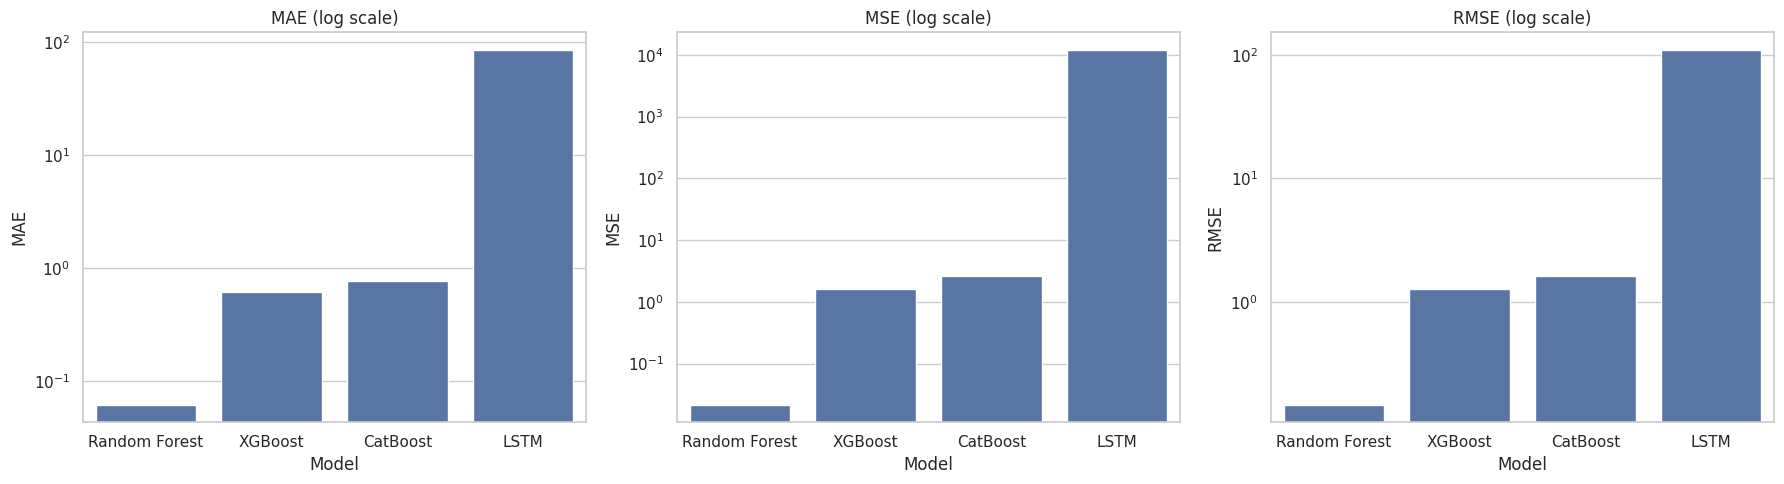

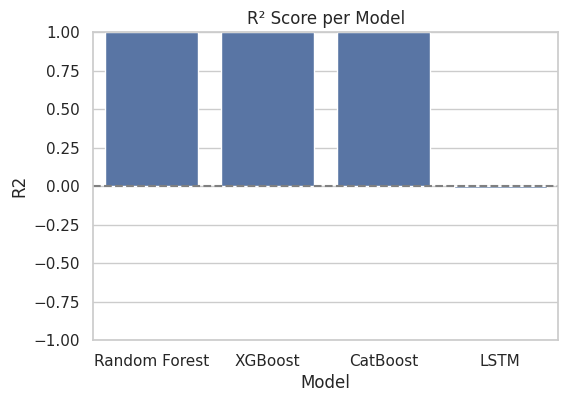

In [39]:
metrics = ['MAE', 'MSE', 'RMSE']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=results, ax=axes[i])
    axes[i].set_yscale('log')
    axes[i].set_title(f'{metric} (log scale)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='R2', data=results)
plt.title('R² Score per Model')
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.show()


## **Predict**

In [40]:
index_sample = 2
pred_dict = {'y_true': y_test_rf.iloc[index_sample]}
for name, model in {'RandomForest': rf_model, 'XGBoost': xgb_model, 'CatBoost': cat_model}.items():
    pred = model.predict(X_test_rf.iloc[[index_sample]])[0]
    pred_dict[f'pred_{name}'] = round(pred, 2)

lstm_sample = lstm_model.predict(X_test_lstm[index_sample:index_sample+1])[0][0]
dummy = np.zeros((1, len(features)))
dummy[:, features.index('Sales')] = lstm_sample
pred_dict['pred_LSTM'] = round(scaler.inverse_transform(dummy)[0][features.index('Sales')], 2)

print(pd.DataFrame([pred_dict]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
    y_true  pred_RandomForest  pred_XGBoost  pred_CatBoost  pred_LSTM
0  209.986             209.94    210.369995         210.36      99.38


Dari hasil prediksi ini, terlihat bahwa Random Forest, XGBoost, dan CatBoost mampu memprediksi nilai penjualan dengan sangat akurat, sedangkan LSTM meleset jauh dari nilai sebenarnya.

**Kesimpulan:**
Model berbasis pohon keputusan (Random Forest, XGBoost, CatBoost) sangat efektif dalam memprediksi penjualan pada dataset ini, dengan Random Forest sebagai model terbaik. Model LSTM tidak direkomendasikan untuk kasus ini karena performanya yang jauh tertinggal.

In [41]:
n = 100
df_plot = pd.DataFrame()
df_plot['Tanggal'] = rf_data.loc[y_test_rf.iloc[:n].index, 'Order Date'].values # Use rf_data instead of X_test_rf
df_plot['Tanggal'] = pd.to_datetime(df_plot['Tanggal'])  # pastikan datetime
df_plot['Bulan'] = df_plot['Tanggal'].dt.to_period('M').dt.to_timestamp()
df_plot['Aktual'] = y_test_rf.iloc[:n].values

In [42]:
for name, model in {'RandomForest': rf_model, 'XGBoost': xgb_model, 'CatBoost': cat_model}.items():
    df_plot[name] = model.predict(X_test_rf.iloc[:n])

lstm_samples = lstm_model.predict(X_test_lstm[:n])
dummy = np.zeros((n, len(features)))
dummy[:, features.index('Sales')] = lstm_samples.flatten()
df_plot['LSTM'] = scaler.inverse_transform(dummy)[:, features.index('Sales')]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


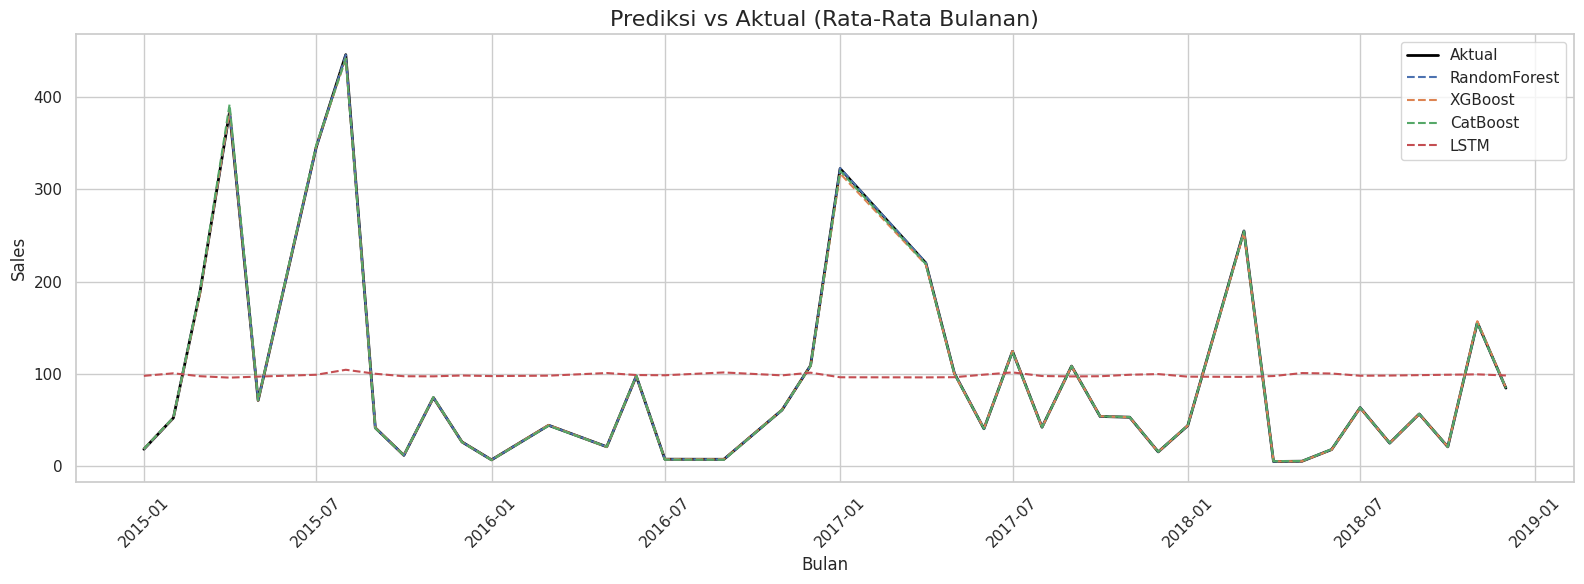

In [43]:
# Agregasi nilai per bulan (rata-rata)
df_bulanan = df_plot.groupby('Bulan', as_index=True).mean(numeric_only=True)

plt.figure(figsize=(16, 6))
plt.plot(df_bulanan.index, df_bulanan['Aktual'], label='Aktual', linewidth=2, color='black')
plt.plot(df_bulanan.index, df_bulanan['RandomForest'], label='RandomForest', linestyle='--')
plt.plot(df_bulanan.index, df_bulanan['XGBoost'], label='XGBoost', linestyle='--')
plt.plot(df_bulanan.index, df_bulanan['CatBoost'], label='CatBoost', linestyle='--')
plt.plot(df_bulanan.index, df_bulanan['LSTM'], label='LSTM', linestyle='--')

plt.title('Prediksi vs Aktual (Rata-Rata Bulanan)', fontsize=16)
plt.xlabel('Bulan')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
pip freeze > requirements.txt